# Research work: Estimating PageRank with inductive capability of Graph Neural Networks and zone partitioning

## Experiment 1: Planetoid.Cora Dataset

Three neural networks were created for computing
zone partitions metrics

In [45]:
#%matplotlib notebook
from models import GCN, GraphSage, ChebyshevNet
import numpy as np
import matplotlib.pyplot as plt
from graph_utils import PartitionFactory
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from sklearn.metrics import classification_report 
from graph_utils import plot_losses

In [2]:
''' Dataset selection '''
dataset = Planetoid(root='data/Planetoid', name='Cora',
                    transform=NormalizeFeatures())
data = dataset[0]

## Graph Partitioning stage: 
This stage separates graph onto 5 different zones

In [3]:
''' PLanetoid Zone Partitions '''

zone_partitioner = PartitionFactory(data, 1209, 7, 4, 3)  # Meta parameters
zone_partitioner.create_partitions()  # compute the partitions
train_mask_1 = torch.tensor(zone_partitioner.get_core_zone1(
    bool_list=True))  # core zone, 1st graph
test_mask_1 = torch.tensor(zone_partitioner.get_undiscovered_zone1(
    bool_list=True))  # undiscovered zone, 1st graph
train_mask_2 = torch.tensor(zone_partitioner.get_core_zone2(
    bool_list=True))  # core zone, 2nd graph
test_mask_2 = torch.tensor(zone_partitioner.get_undiscovered_zone2(
    bool_list=True))  # undiscovered zone, 2nd graph
intersection_mask = torch.tensor(zone_partitioner.get_intersection_zone(
    bool_list=True))  # intersection zone

#### Graph Partitioning labels ###
- Core Zone 1: GREEN
- Undiscovered zone 1: YELLOW
- Core Zone 2: BLUE
- Undiscovered zone 2: ORANGE
- Intersection zone: RED
- Other nodes: GREY

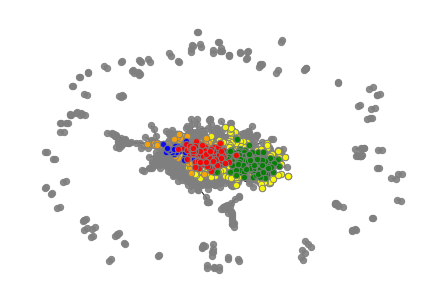

In [4]:
zone_partitioner.plot_partitions()

In [5]:
print(zone_partitioner)


--------------------------
Partition Report:
--------------------------
first seed id: 1209
distance to the second seed: 7
core depth: 4
undiscovered zone's depth: 3
--------------------------
Node number in zones:
--------------------------
core zone_1: 384
undiscovered zone_1: 837
core zone_2: 40
undiscovered zone_2: 242
intersection zone: 128
--------------------------



### Train Test and Intersection Test utils

In [32]:
def train(nn_model, data, optimizer, criterion, train_mask):
    nn_model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = nn_model(data.x, data.edge_index)  # Perform a single forward pass.
    # Compute the loss solely based on the training nodes.
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss


def test(nn_model, data, test_mask, target_names):
    nn_model.eval()
    out = nn_model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    # Check against ground-truth labels.
    test_correct = pred[test_mask] == data.y[test_mask]
    # Derive ratio of correct predictions.
    test_acc = int(test_correct.sum()) / test_mask.sum()
    report = classification_report(pred[intersection_mask],
        data.y[intersection_mask],
        target_names=target_names,
        zero_division=1)
    return test_acc, report

def test_intersection(nn_model1, nn_model2, data, intersection_mask, target_names):
    "The Intersection zone: tested by both neural networks"
    nn_model1.eval()
    nn_model2.eval()

    out1 = nn_model1(data.x, data.edge_index)
    out2 = nn_model2(data.x, data.edge_index)

    # get the data from the both predictions
    pred = ((out1 + out2)/2).argmax(dim=1)

    # Check against ground-truth labels.
    test_correct = pred[intersection_mask] == data.y[intersection_mask]
    # Derive ratio of correct predictions.
    test_acc = int(test_correct.sum()) / intersection_mask.sum()

    report = classification_report(pred[intersection_mask],
        data.y[intersection_mask],
        target_names=target_names,
        zero_division=1)
    return test_acc, report

def test_intersection_weighted(nn_model1, nn_model2, data, test_mask1, test_mask2, intersection_mask, target_names):
    "The Intersection zone: tested by both neural networks"
    nn_model1.eval()
    nn_model2.eval()

    out1 = nn_model1(data.x, data.edge_index)
    out2 = nn_model2(data.x, data.edge_index)

    # calculate weights with regarding proportion
    core_number_1 = torch.sum(test_mask1).float() # number of nodes in core zone 1
    core_number_2 = torch.sum(test_mask2).float() # number of nodes in core zone 2
    core_number_total = core_number_1 + core_number_2 # total in core number
    weight1 = core_number_1 / core_number_total
    weight2 = core_number_2 / core_number_total
    
    # get the data from the both predictions by calculating the average with regarding the proportion of train data
    pred = ((weight1 * out1 + weight2 * out2)/2).argmax(dim=1)

    # Check against ground-truth labels.
    test_correct = pred[intersection_mask] == data.y[intersection_mask]
    # Derive ratio of correct predictions.
    test_acc = int(test_correct.sum()) / intersection_mask.sum()

    report = classification_report(pred[intersection_mask],
        data.y[intersection_mask],
        target_names=target_names,
        zero_division=1)
    return test_acc, report

print(f"{torch.sum(train_mask_1).float()} {torch.sum(train_mask_2).float()}")

384.0 40.0


## Model1: GraphConv

In [33]:
model1 = GCN(dataset, hidden_channels=16)
model2 = GCN(dataset, hidden_channels=16)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.01, weight_decay=5e-4)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.01, weight_decay=5e-4)
criterion1 = torch.nn.CrossEntropyLoss()
criterion2 = torch.nn.CrossEntropyLoss()

In [34]:
loss_list1 = []
loss_list2 = []

for epoch in range(1, 500):
    loss1 = train(model1, data, optimizer1, criterion1, train_mask_1)
    loss2 = train(model2, data, optimizer2, criterion2, train_mask_2)
    loss_list1.append(loss1.item())
    loss_list2.append(loss2.item())
    print(f'Epoch: {epoch:03d}')
    print(f'NN1:{loss1:.4f}, NN2: {loss2:.4f}')

Epoch: 001
NN1:1.9468, NN2: 1.9469
Epoch: 002
NN1:1.9090, NN2: 1.9186
Epoch: 003
NN1:1.8655, NN2: 1.8886
Epoch: 004
NN1:1.8270, NN2: 1.8505
Epoch: 005
NN1:1.7765, NN2: 1.8168
Epoch: 006
NN1:1.7337, NN2: 1.7816
Epoch: 007
NN1:1.6867, NN2: 1.7563
Epoch: 008
NN1:1.6189, NN2: 1.6991
Epoch: 009
NN1:1.5753, NN2: 1.6662
Epoch: 010
NN1:1.5428, NN2: 1.6411
Epoch: 011
NN1:1.4578, NN2: 1.5523
Epoch: 012
NN1:1.4229, NN2: 1.4764
Epoch: 013
NN1:1.3688, NN2: 1.4916
Epoch: 014
NN1:1.3139, NN2: 1.3620
Epoch: 015
NN1:1.2520, NN2: 1.2961
Epoch: 016
NN1:1.2252, NN2: 1.2670
Epoch: 017
NN1:1.1482, NN2: 1.2296
Epoch: 018
NN1:1.1262, NN2: 1.1798
Epoch: 019
NN1:1.0923, NN2: 1.1337
Epoch: 020
NN1:1.0903, NN2: 1.0515
Epoch: 021
NN1:1.0183, NN2: 0.9848
Epoch: 022
NN1:1.0121, NN2: 1.0034
Epoch: 023
NN1:1.0262, NN2: 0.9334
Epoch: 024
NN1:1.0114, NN2: 0.9150
Epoch: 025
NN1:1.0124, NN2: 0.8782
Epoch: 026
NN1:0.9942, NN2: 0.8252
Epoch: 027
NN1:0.9890, NN2: 0.8416
Epoch: 028
NN1:0.9783, NN2: 0.7573
Epoch: 029
NN1:0.956

NN1:0.4789, NN2: 0.2258
Epoch: 240
NN1:0.4845, NN2: 0.1873
Epoch: 241
NN1:0.5135, NN2: 0.2328
Epoch: 242
NN1:0.4722, NN2: 0.1935
Epoch: 243
NN1:0.4442, NN2: 0.2084
Epoch: 244
NN1:0.4494, NN2: 0.2046
Epoch: 245
NN1:0.4703, NN2: 0.1803
Epoch: 246
NN1:0.4479, NN2: 0.2168
Epoch: 247
NN1:0.4703, NN2: 0.1948
Epoch: 248
NN1:0.4478, NN2: 0.2427
Epoch: 249
NN1:0.4501, NN2: 0.1999
Epoch: 250
NN1:0.4763, NN2: 0.2268
Epoch: 251
NN1:0.4502, NN2: 0.2227
Epoch: 252
NN1:0.4523, NN2: 0.1799
Epoch: 253
NN1:0.4575, NN2: 0.2878
Epoch: 254
NN1:0.4385, NN2: 0.2175
Epoch: 255
NN1:0.4548, NN2: 0.1877
Epoch: 256
NN1:0.4643, NN2: 0.2563
Epoch: 257
NN1:0.4577, NN2: 0.2330
Epoch: 258
NN1:0.4751, NN2: 0.2110
Epoch: 259
NN1:0.4493, NN2: 0.2079
Epoch: 260
NN1:0.4633, NN2: 0.1938
Epoch: 261
NN1:0.4467, NN2: 0.1661
Epoch: 262
NN1:0.4535, NN2: 0.1520
Epoch: 263
NN1:0.4428, NN2: 0.2091
Epoch: 264
NN1:0.4592, NN2: 0.2034
Epoch: 265
NN1:0.4537, NN2: 0.1624
Epoch: 266
NN1:0.4722, NN2: 0.1945
Epoch: 267
NN1:0.4736, NN2: 0.2

Epoch: 476
NN1:0.3186, NN2: 0.1446
Epoch: 477
NN1:0.3469, NN2: 0.2051
Epoch: 478
NN1:0.3184, NN2: 0.1369
Epoch: 479
NN1:0.3374, NN2: 0.1550
Epoch: 480
NN1:0.3810, NN2: 0.1374
Epoch: 481
NN1:0.3555, NN2: 0.1365
Epoch: 482
NN1:0.3430, NN2: 0.1707
Epoch: 483
NN1:0.3333, NN2: 0.1465
Epoch: 484
NN1:0.3563, NN2: 0.1525
Epoch: 485
NN1:0.3466, NN2: 0.1422
Epoch: 486
NN1:0.3520, NN2: 0.0973
Epoch: 487
NN1:0.3571, NN2: 0.1278
Epoch: 488
NN1:0.3544, NN2: 0.1413
Epoch: 489
NN1:0.3539, NN2: 0.2246
Epoch: 490
NN1:0.3475, NN2: 0.1142
Epoch: 491
NN1:0.3286, NN2: 0.1568
Epoch: 492
NN1:0.3404, NN2: 0.1431
Epoch: 493
NN1:0.3674, NN2: 0.1652
Epoch: 494
NN1:0.3299, NN2: 0.1065
Epoch: 495
NN1:0.3512, NN2: 0.1332
Epoch: 496
NN1:0.3657, NN2: 0.1768
Epoch: 497
NN1:0.3456, NN2: 0.1709
Epoch: 498
NN1:0.3292, NN2: 0.1262
Epoch: 499
NN1:0.3423, NN2: 0.1929


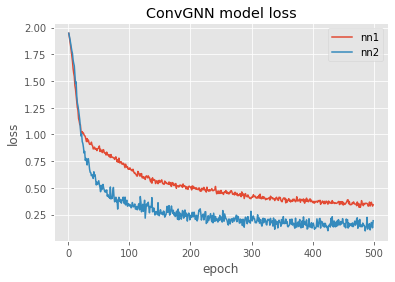

In [35]:
plot_losses(loss_list1, loss_list2, "ConvGNN")

In [37]:
target_names=['c1','c2', 'c3','c4','c5','c6','c7']
test_acc_1, report_1 = test(model1, data, test_mask_1, target_names)
test_acc_2, report_2 = test(model2, data, test_mask_2, target_names)
test_acc_intersection, report_intersection = test_intersection(
    model1, model2, data, intersection_mask, target_names)

test_acc_intersection_weighted, report_intersection_weighted = test_intersection_weighted(model1,
                                                                                          model2,
                                                                                          data,
                                                                                          test_mask_1,
                                                                                          test_mask_2,
                                                                                          intersection_mask,
                                                                                          target_names)

print(f"NN1 Acc:{test_acc_1:.5}, NN2 Acc: {test_acc_2:.5}, ")
print(f"Intersection Acc: {test_acc_intersection:.5}, Intersection weighed: {test_acc_intersection_weighted}")
print('----------------------------------------------------------------------------------')
print('NN1 REPORT')
print(report_1)
print('NN2 REPORT')
print(report_2)
print('NN3 REPORT')
print(report_intersection)

NN1 Acc:0.6141, NN2 Acc: 0.51653, 
Intersection Acc: 0.64062, Intersection weighed: 0.65625
----------------------------------------------------------------------------------
NN1 REPORT
              precision    recall  f1-score   support

          c1       0.00      1.00      0.00         0
          c2       0.71      0.71      0.71         7
          c3       0.80      0.17      0.28        24
          c4       0.85      0.71      0.78        90
          c5       0.00      1.00      0.00         0
          c6       0.25      0.14      0.18         7
          c7       0.00      1.00      0.00         0

    accuracy                           0.58       128
   macro avg       0.37      0.68      0.28       128
weighted avg       0.80      0.58      0.65       128

NN2 REPORT
              precision    recall  f1-score   support

          c1       1.00      0.41      0.58        32
          c2       0.00      1.00      0.00         0
          c3       0.00      1.00      0.00

## Model 2: GraphSage

In [38]:
model1 = GraphSage(dataset, hidden_channels=16)
model2 = GraphSage(dataset, hidden_channels=16)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.01, weight_decay=5e-4)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.01, weight_decay=5e-4)
criterion1 = torch.nn.CrossEntropyLoss()
criterion2 = torch.nn.CrossEntropyLoss()

In [39]:
loss_list1 = []
loss_list2 = []

for epoch in range(1, 500):
    loss1 = train(model1, data, optimizer1, criterion1, train_mask_1)
    loss2 = train(model2, data, optimizer2, criterion2, train_mask_2)
    loss_list1.append(loss1.item())
    loss_list2.append(loss2.item())
    print(f'Epoch: {epoch:03d}')
    print(f'NN1:{loss1:.4f}, NN2: {loss2:.4f}')

Epoch: 001
NN1:1.8087, NN2: 2.0861
Epoch: 002
NN1:1.7799, NN2: 2.0638
Epoch: 003
NN1:1.7457, NN2: 2.0309
Epoch: 004
NN1:1.7148, NN2: 1.9954
Epoch: 005
NN1:1.6640, NN2: 1.9504
Epoch: 006
NN1:1.6166, NN2: 1.9102
Epoch: 007
NN1:1.5289, NN2: 1.8423
Epoch: 008
NN1:1.4728, NN2: 1.7583
Epoch: 009
NN1:1.3820, NN2: 1.7187
Epoch: 010
NN1:1.3200, NN2: 1.6134
Epoch: 011
NN1:1.2772, NN2: 1.5567
Epoch: 012
NN1:1.1203, NN2: 1.3976
Epoch: 013
NN1:1.1123, NN2: 1.2950
Epoch: 014
NN1:1.0471, NN2: 1.2138
Epoch: 015
NN1:0.9502, NN2: 1.1756
Epoch: 016
NN1:0.9428, NN2: 1.0209
Epoch: 017
NN1:0.9142, NN2: 0.9050
Epoch: 018
NN1:0.8703, NN2: 0.8910
Epoch: 019
NN1:0.8641, NN2: 0.8403
Epoch: 020
NN1:0.8817, NN2: 0.7098
Epoch: 021
NN1:0.8483, NN2: 0.6719
Epoch: 022
NN1:0.8446, NN2: 0.6802
Epoch: 023
NN1:0.8582, NN2: 0.6717
Epoch: 024
NN1:0.8120, NN2: 0.5978
Epoch: 025
NN1:0.8353, NN2: 0.5695
Epoch: 026
NN1:0.8124, NN2: 0.6027
Epoch: 027
NN1:0.7977, NN2: 0.5612
Epoch: 028
NN1:0.7880, NN2: 0.5217
Epoch: 029
NN1:0.808

Epoch: 236
NN1:0.2342, NN2: 0.0197
Epoch: 237
NN1:0.2107, NN2: 0.0473
Epoch: 238
NN1:0.2083, NN2: 0.0987
Epoch: 239
NN1:0.2098, NN2: 0.0262
Epoch: 240
NN1:0.1948, NN2: 0.0470
Epoch: 241
NN1:0.2132, NN2: 0.0498
Epoch: 242
NN1:0.2285, NN2: 0.0442
Epoch: 243
NN1:0.2127, NN2: 0.0710
Epoch: 244
NN1:0.2399, NN2: 0.0556
Epoch: 245
NN1:0.2002, NN2: 0.0398
Epoch: 246
NN1:0.2026, NN2: 0.0591
Epoch: 247
NN1:0.2325, NN2: 0.0724
Epoch: 248
NN1:0.2020, NN2: 0.0300
Epoch: 249
NN1:0.2013, NN2: 0.0333
Epoch: 250
NN1:0.1808, NN2: 0.1318
Epoch: 251
NN1:0.1961, NN2: 0.0445
Epoch: 252
NN1:0.2057, NN2: 0.0472
Epoch: 253
NN1:0.2014, NN2: 0.0432
Epoch: 254
NN1:0.2066, NN2: 0.1015
Epoch: 255
NN1:0.2211, NN2: 0.0560
Epoch: 256
NN1:0.2240, NN2: 0.1019
Epoch: 257
NN1:0.2229, NN2: 0.0414
Epoch: 258
NN1:0.2126, NN2: 0.0711
Epoch: 259
NN1:0.2083, NN2: 0.0493
Epoch: 260
NN1:0.2155, NN2: 0.0160
Epoch: 261
NN1:0.1939, NN2: 0.0816
Epoch: 262
NN1:0.2084, NN2: 0.0389
Epoch: 263
NN1:0.2308, NN2: 0.0234
Epoch: 264
NN1:0.196

Epoch: 471
NN1:0.1525, NN2: 0.0548
Epoch: 472
NN1:0.1688, NN2: 0.0328
Epoch: 473
NN1:0.1429, NN2: 0.0333
Epoch: 474
NN1:0.1464, NN2: 0.0467
Epoch: 475
NN1:0.1353, NN2: 0.0452
Epoch: 476
NN1:0.1563, NN2: 0.0375
Epoch: 477
NN1:0.1742, NN2: 0.0202
Epoch: 478
NN1:0.1451, NN2: 0.0395
Epoch: 479
NN1:0.1521, NN2: 0.0741
Epoch: 480
NN1:0.1369, NN2: 0.0647
Epoch: 481
NN1:0.1316, NN2: 0.0307
Epoch: 482
NN1:0.1343, NN2: 0.0255
Epoch: 483
NN1:0.1526, NN2: 0.0142
Epoch: 484
NN1:0.1444, NN2: 0.0413
Epoch: 485
NN1:0.1398, NN2: 0.0114
Epoch: 486
NN1:0.1551, NN2: 0.0165
Epoch: 487
NN1:0.1573, NN2: 0.0211
Epoch: 488
NN1:0.1497, NN2: 0.0311
Epoch: 489
NN1:0.1331, NN2: 0.0148
Epoch: 490
NN1:0.1571, NN2: 0.0454
Epoch: 491
NN1:0.1443, NN2: 0.0222
Epoch: 492
NN1:0.1135, NN2: 0.0152
Epoch: 493
NN1:0.1427, NN2: 0.0288
Epoch: 494
NN1:0.1262, NN2: 0.0259
Epoch: 495
NN1:0.1446, NN2: 0.0389
Epoch: 496
NN1:0.1316, NN2: 0.0436
Epoch: 497
NN1:0.1432, NN2: 0.0192
Epoch: 498
NN1:0.1372, NN2: 0.0415
Epoch: 499
NN1:0.148

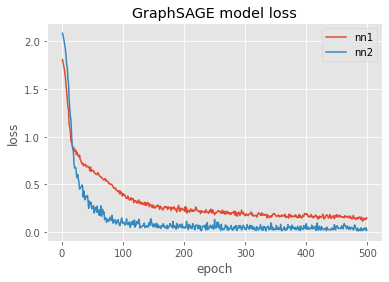

In [40]:
plot_losses(loss_list1, loss_list2, 'GraphSAGE')

In [41]:
target_names=['c1','c2', 'c3','c4','c5','c6','c7']
test_acc_1, report_1 = test(model1, data, test_mask_1, target_names)
test_acc_2, report_2 = test(model2, data, test_mask_2, target_names)
test_acc_intersection, report_intersection = test_intersection(
    model1, model2, data, intersection_mask, target_names)

test_acc_intersection_weighted, report_intersection_weighted = test_intersection_weighted(model1,
                                                                                          model2,
                                                                                          data,
                                                                                          test_mask_1,
                                                                                          test_mask_2,
                                                                                          intersection_mask,
                                                                                          target_names)

print(f"NN1 Acc:{test_acc_1:.5}, NN2 Acc: {test_acc_2:.5}, ")
print(f"Intersection Acc: {test_acc_intersection:.5}, Intersection weighed: {test_acc_intersection_weighted}")
print('----------------------------------------------------------------------------------')
print('NN1 REPORT')
print(report_1)
print('NN2 REPORT')
print(report_2)
print('NN3 REPORT')
print(report_intersection)

NN1 Acc:0.68459, NN2 Acc: 0.53306, 
Intersection Acc: 0.625, Intersection weighed: 0.703125
----------------------------------------------------------------------------------
NN1 REPORT
              precision    recall  f1-score   support

          c1       0.31      0.44      0.36         9
          c2       0.43      0.60      0.50         5
          c3       0.80      0.27      0.40        15
          c4       0.91      0.72      0.80        94
          c5       0.00      1.00      0.00         0
          c6       0.25      0.20      0.22         5
          c7       0.00      1.00      0.00         0

    accuracy                           0.62       128
   macro avg       0.38      0.60      0.33       128
weighted avg       0.81      0.62      0.69       128

NN2 REPORT
              precision    recall  f1-score   support

          c1       0.92      0.63      0.75        19
          c2       0.00      1.00      0.00         0
          c3       0.00      1.00      0.00

## Model 3: ChebNet

In [46]:
model1 = ChebyshevNet(dataset, hidden_channels=16, k_parameter=3)
model2 = ChebyshevNet(dataset, hidden_channels=16, k_parameter=3)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.01, weight_decay=5e-4)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.01, weight_decay=5e-4)
criterion1 = torch.nn.CrossEntropyLoss()
criterion2 = torch.nn.CrossEntropyLoss()

In [47]:
loss_list1 = []
loss_list2 = []

for epoch in range(1, 500):
    loss1 = train(model1, data, optimizer1, criterion1, train_mask_1)
    loss2 = train(model2, data, optimizer2, criterion2, train_mask_2)
    loss_list1.append(loss1.item())
    loss_list2.append(loss2.item())
    print(f'Epoch: {epoch:03d}')
    print(f'NN1:{loss1:.4f}, NN2: {loss2:.4f}')

Epoch: 001
NN1:1.9508, NN2: 1.9486
Epoch: 002
NN1:1.8769, NN2: 1.8625
Epoch: 003
NN1:1.8131, NN2: 1.7576
Epoch: 004
NN1:1.7239, NN2: 1.6680
Epoch: 005
NN1:1.6143, NN2: 1.5600
Epoch: 006
NN1:1.5448, NN2: 1.4772
Epoch: 007
NN1:1.4312, NN2: 1.3198
Epoch: 008
NN1:1.3660, NN2: 1.2924
Epoch: 009
NN1:1.2369, NN2: 1.0347
Epoch: 010
NN1:1.1678, NN2: 1.0092
Epoch: 011
NN1:1.1152, NN2: 0.9814
Epoch: 012
NN1:1.1084, NN2: 0.8071
Epoch: 013
NN1:0.9942, NN2: 0.8083
Epoch: 014
NN1:0.9862, NN2: 0.7638
Epoch: 015
NN1:0.9298, NN2: 0.6404
Epoch: 016
NN1:0.9563, NN2: 0.5717
Epoch: 017
NN1:0.9583, NN2: 0.6295
Epoch: 018
NN1:0.9463, NN2: 0.4769
Epoch: 019
NN1:0.8748, NN2: 0.4974
Epoch: 020
NN1:0.8629, NN2: 0.4309
Epoch: 021
NN1:0.8344, NN2: 0.4681
Epoch: 022
NN1:0.8741, NN2: 0.3016
Epoch: 023
NN1:0.7926, NN2: 0.3853
Epoch: 024
NN1:0.8114, NN2: 0.3694
Epoch: 025
NN1:0.7977, NN2: 0.2941
Epoch: 026
NN1:0.7733, NN2: 0.2742
Epoch: 027
NN1:0.7711, NN2: 0.2762
Epoch: 028
NN1:0.7177, NN2: 0.2151
Epoch: 029
NN1:0.715

Epoch: 236
NN1:0.1795, NN2: 0.0243
Epoch: 237
NN1:0.1701, NN2: 0.0211
Epoch: 238
NN1:0.1458, NN2: 0.0441
Epoch: 239
NN1:0.1743, NN2: 0.0326
Epoch: 240
NN1:0.1548, NN2: 0.0296
Epoch: 241
NN1:0.1851, NN2: 0.0679
Epoch: 242
NN1:0.1631, NN2: 0.0487
Epoch: 243
NN1:0.1710, NN2: 0.0351
Epoch: 244
NN1:0.1459, NN2: 0.0339
Epoch: 245
NN1:0.1646, NN2: 0.0658
Epoch: 246
NN1:0.1632, NN2: 0.0415
Epoch: 247
NN1:0.1851, NN2: 0.0156
Epoch: 248
NN1:0.1556, NN2: 0.0159
Epoch: 249
NN1:0.1552, NN2: 0.0317
Epoch: 250
NN1:0.1549, NN2: 0.0202
Epoch: 251
NN1:0.1598, NN2: 0.0309
Epoch: 252
NN1:0.1688, NN2: 0.0271
Epoch: 253
NN1:0.1670, NN2: 0.0498
Epoch: 254
NN1:0.1544, NN2: 0.0235
Epoch: 255
NN1:0.1553, NN2: 0.0443
Epoch: 256
NN1:0.1647, NN2: 0.0496
Epoch: 257
NN1:0.1507, NN2: 0.0121
Epoch: 258
NN1:0.1522, NN2: 0.0142
Epoch: 259
NN1:0.1433, NN2: 0.0172
Epoch: 260
NN1:0.1687, NN2: 0.0409
Epoch: 261
NN1:0.1495, NN2: 0.0422
Epoch: 262
NN1:0.1333, NN2: 0.0168
Epoch: 263
NN1:0.1628, NN2: 0.0205
Epoch: 264
NN1:0.149

Epoch: 471
NN1:0.1205, NN2: 0.0255
Epoch: 472
NN1:0.1148, NN2: 0.0264
Epoch: 473
NN1:0.1076, NN2: 0.0131
Epoch: 474
NN1:0.1367, NN2: 0.0235
Epoch: 475
NN1:0.1219, NN2: 0.0192
Epoch: 476
NN1:0.1494, NN2: 0.0450
Epoch: 477
NN1:0.1362, NN2: 0.0116
Epoch: 478
NN1:0.1383, NN2: 0.0334
Epoch: 479
NN1:0.1380, NN2: 0.0158
Epoch: 480
NN1:0.1440, NN2: 0.0094
Epoch: 481
NN1:0.1198, NN2: 0.0108
Epoch: 482
NN1:0.1293, NN2: 0.0298
Epoch: 483
NN1:0.1312, NN2: 0.0446
Epoch: 484
NN1:0.1292, NN2: 0.0129
Epoch: 485
NN1:0.1175, NN2: 0.0103
Epoch: 486
NN1:0.1189, NN2: 0.0088
Epoch: 487
NN1:0.1208, NN2: 0.0295
Epoch: 488
NN1:0.1297, NN2: 0.0080
Epoch: 489
NN1:0.1290, NN2: 0.0387
Epoch: 490
NN1:0.1321, NN2: 0.0149
Epoch: 491
NN1:0.1250, NN2: 0.0374
Epoch: 492
NN1:0.1095, NN2: 0.0197
Epoch: 493
NN1:0.1242, NN2: 0.0365
Epoch: 494
NN1:0.1518, NN2: 0.0081
Epoch: 495
NN1:0.1436, NN2: 0.0269
Epoch: 496
NN1:0.1161, NN2: 0.0359
Epoch: 497
NN1:0.1270, NN2: 0.0138
Epoch: 498
NN1:0.1263, NN2: 0.0086
Epoch: 499
NN1:0.135

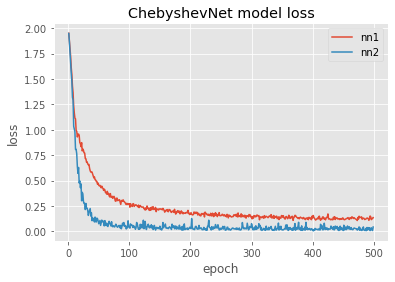

In [48]:
plot_losses(loss_list1, loss_list2, 'ChebyshevNet')

In [49]:
target_names=['c1','c2', 'c3','c4','c5','c6','c7']
test_acc_1, report_1 = test(model1, data, test_mask_1, target_names)
test_acc_2, report_2 = test(model2, data, test_mask_2, target_names)
test_acc_intersection, report_intersection = test_intersection(
    model1, model2, data, intersection_mask, target_names)

test_acc_intersection_weighted, report_intersection_weighted = test_intersection_weighted(model1,
                                                                                          model2,
                                                                                          data,
                                                                                          test_mask_1,
                                                                                          test_mask_2,
                                                                                          intersection_mask,
                                                                                          target_names)

print(f"NN1 Acc:{test_acc_1:.5}, NN2 Acc: {test_acc_2:.5}, ")
print(f"Intersection Acc: {test_acc_intersection:.5}, Intersection weighed: {test_acc_intersection_weighted}")
print('----------------------------------------------------------------------------------')
print('NN1 REPORT')
print(report_1)
print('NN2 REPORT')
print(report_2)
print('NN3 REPORT')
print(report_intersection)

NN1 Acc:0.61768, NN2 Acc: 0.49587, 
Intersection Acc: 0.54688, Intersection weighed: 0.65625
----------------------------------------------------------------------------------
NN1 REPORT
              precision    recall  f1-score   support

          c1       0.38      0.56      0.45         9
          c2       0.57      0.67      0.62         6
          c3       1.00      0.22      0.36        23
          c4       0.81      0.71      0.76        86
          c5       0.00      1.00      0.00         0
          c6       0.25      0.25      0.25         4
          c7       0.00      1.00      0.00         0

    accuracy                           0.59       128
   macro avg       0.43      0.63      0.35       128
weighted avg       0.79      0.59      0.64       128

NN2 REPORT
              precision    recall  f1-score   support

          c1       0.92      0.50      0.65        24
          c2       0.00      1.00      0.00         0
          c3       0.00      1.00      0.0